# Vector Quantizer (VQ) and Linde-Buzo-Gray (LBG) Algorithm

In [1]:
# Libraries
import librosa as lbr
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
# Parameters
Fs = 32000   # Sampling frequency
T=1/Fs       # Sampling Period
t = np.arange(Fs)*T # Time vector 1 second

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


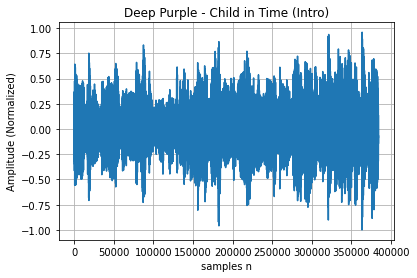

In [6]:
# Load audio file
speech_signal , sr =lbr.load('Deep Purple_Child In Time.mp3', sr=Fs, offset=13, duration=12)

# Normalize Audio
speech_signal/=np.abs(speech_signal).max()

# Plot Audio
plt.figure()
plt.plot(speech_signal)
plt.title('Deep Purple - Child in Time (Intro)')
plt.xlabel('samples n')
plt.ylabel('Amplitude (Normalized)');
plt.grid()

# Listen
display(ipd.Audio(speech_signal, rate = Fs ))

Now plot the 2 dimensional vectors, with their sample values of even indices on the x axes, and their sample values of odd indices on the y axis. Each such pair is plotted as a ‘+’:

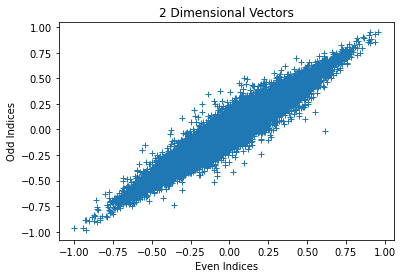

In [7]:
plt.figure()
plt.plot(speech_signal[2::2], speech_signal[1:-1:2], '+')
plt.title('2 Dimensional Vectors')
plt.xlabel('Even Indices')
plt.ylabel('Odd Indices');

Since the odd and the even samples are similar to each other, we get a distribution of vector points near the diagonal of the space! Hence we also need to sample this space only near the diagonal, or more generally speaking, we should sample more densely near this diagonal.

## Vector Quantization in an Encoder and Decoder

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


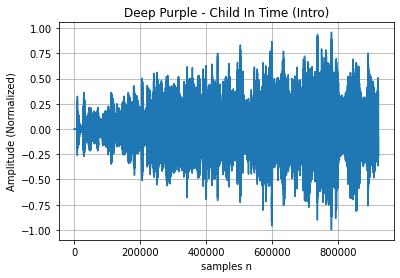

In [8]:
# Training Set
training_signal , sr = lbr.load('Deep Purple_Child In Time.mp3', sr=Fs, offset=0, duration=28.8)

# Normalize Audio
training_signal/=np.abs(training_signal).max()

# Plot Audio
plt.figure()
plt.plot(training_signal)
plt.title('Deep Purple - Child In Time (Intro)')
plt.xlabel('samples n')
plt.ylabel('Amplitude (Normalized)');
plt.grid()

# Listen
display(ipd.Audio(training_signal, rate = Fs ))

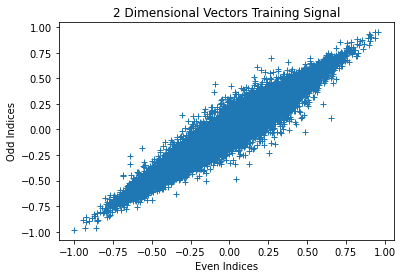

In [9]:
# 2-Dimensional Vector Space of Samples
plt.figure()
training_data=training_signal.reshape(-1,2).astype('double')
plt.plot(list(zip(*training_data))[0],list(zip(*training_data))[1],'+')
plt.title('2 Dimensional Vectors Training Signal')
plt.xlabel('Even Indices')
plt.ylabel('Odd Indices');

In [10]:
np.random.seed(seed=1)
from sklearn.cluster import KMeans

N =  3 #Number of bits
n_clusters = 2**N

kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, max_iter=1000)
kmeans.fit(training_data)

KMeans(max_iter=1000)

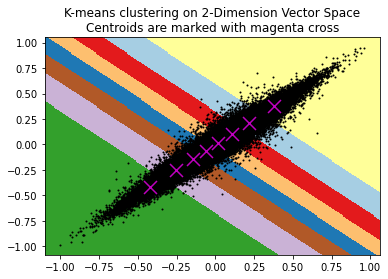

In [11]:
#  Voronoi Visualization
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = training_data[:, 0].min() - 1, training_data[:, 0].max() + 1
y_min, y_max = training_data[:, 1].min() - 1, training_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(training_data[:, 0], training_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='m', zorder=10)
plt.title('K-means clustering on 2-Dimension Vector Space\n'
          'Centroids are marked with magenta cross')
plt.xlim(x_min+0.9, x_max-0.9)
plt.ylim(y_min+0.9, y_max-0.9);
#plt.xticks(())
#plt.yticks(());

In [12]:
centroids
codebook_dict = {ind : val for ind,val in enumerate(centroids.tolist())}
codebook_dict

{0: [0.215173958657117, 0.215268805975478],
 1: [-0.06057338950884843, -0.06045437664491536],
 2: [-0.4204543667230581, -0.42053087259231536],
 3: [0.10706365847597911, 0.10713852643320958],
 4: [0.016175806093081987, 0.016037908731511133],
 5: [-0.2535928072536898, -0.2535073669607635],
 6: [0.3791015062256532, 0.37915643951581535],
 7: [-0.146627418216019, -0.1467805435998317]}

[4 4 4 ... 1 1 1]


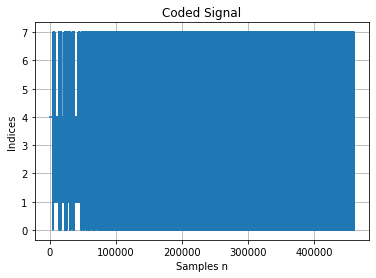

In [13]:
# Indices of Codewords
#k = kmeans.labels_
k = kmeans.predict(training_data)
plt.figure()
plt.plot(k)
print(k)
plt.grid()
plt.title('Coded Signal')
plt.ylabel('Indices')
plt.xlabel('Samples n');

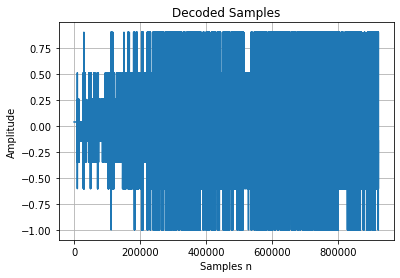

In [14]:
# Decode Indices to Vectors
decoded=np.array([codebook_dict[ind] for ind in k.tolist()])
decoded/=np.abs(decoded).max()

#Vectors to Stream of Samples
decoded=decoded.reshape(-1,)

# Plot Decoded Samples
plt.figure()
plt.plot(decoded)
plt.grid()
plt.title('Decoded Samples')
plt.xlabel('Samples n')
plt.ylabel('Amplitude');

# Listen to Decoded Samples
ipd.Audio(decoded, rate=Fs)